('Datasets:', 'full:', (1309, 12), 'titanic:', (891, 12))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


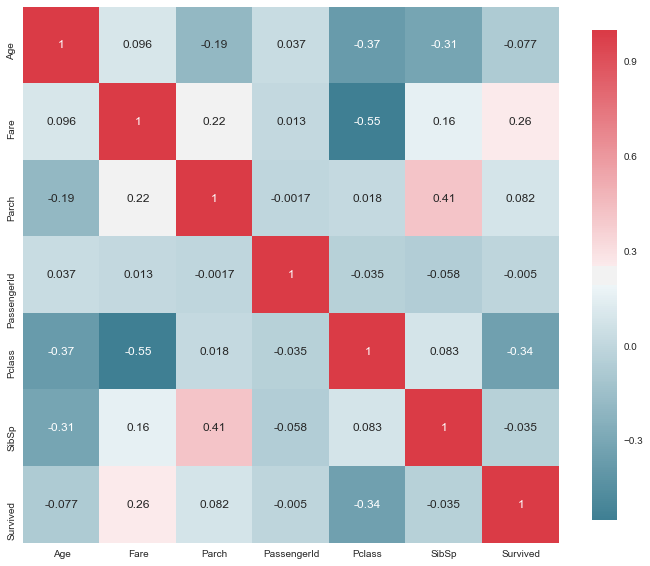

In [71]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

# Visualisation
import matplotlib.pylab as pylab
import seaborn as sns

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# Configure visualisations
#%matplotlib inline
#mpl.style.use( 'ggplot' )
#sns.set_style( 'white' )
#Visualization
#import seaborn as sns
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import matplotlib.pylab as pylab
#pylab.rcParams['figure.figsize'] = 8,6 # Big graphs unless specified
sns.set(color_codes=True) # Set style and color of graphs

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
train = pd.read_csv("/Users/houzhuo/Downloads/train.csv")
test    = pd.read_csv("/Users/houzhuo/Downloads/test.csv")
full = train.append(test,ignore_index=True)
titanic = full[:891]
print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)
full.info()
plot_correlation_map(full)

0       0
1       1
2       0
3       1
4       0
5       0
6       1
7       1
8       1
9       1
10      1
11      0
12      0
13      1
14      0
15      0
16      1
17      0
18      1
19      0
20      1
21      0
22      0
23      0
24      1
25      1
26      0
27      1
28      0
29      0
       ..
1279    0
1280    1
1281    1
1282    1
1283    1
1284    0
1285    1
1286    1
1287    0
1288    1
1289    0
1290    0
1291    1
1292    1
1293    1
1294    1
1295    0
1296    0
1297    0
1298    1
1299    0
1300    1
1301    0
1302    1
1303    0
1304    0
1305    1
1306    0
1307    0
1308    1
Name: TicketCount, Length: 1309, dtype: int64

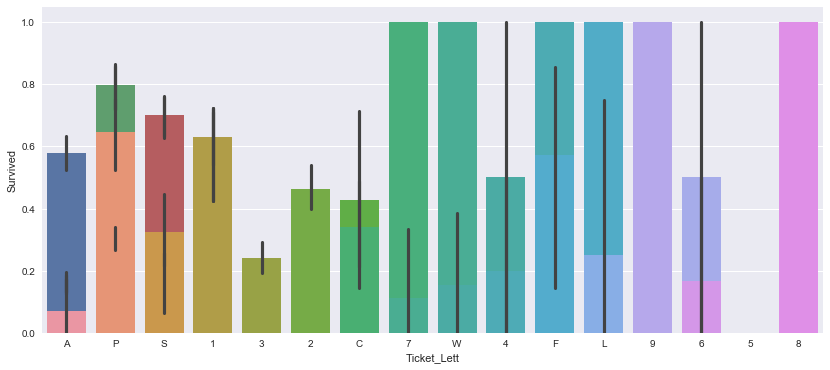

In [72]:
#Title
title = pd.DataFrame()
full['Title'] = full['Name'].map(lambda name:name.split(',')[1].split( '.' )[0].strip())
plt.figure(figsize=(14,6))
sns.barplot('Title', 'Survived', data=full)
#plt.show()
full['Title'] = full['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
full['Title'] = full['Title'].replace(['Mlle','Ms'], 'Miss')
full['Title'] = full['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
title = pd.get_dummies(full['Title'],prefix='Title')
full = pd.concat([full,title],axis=1)
sns.barplot('Title', 'Survived', data=full)

#Age & isChild
group = full.groupby(['Sex','Title', 'Pclass'])['Age']
full['Age'] = group.transform(lambda x: x.fillna(x.median()))
full['IsChild'] = np.where(full['Age']<=12,1,0)
full['IsOld'] = np.where(full['Age']>=63,1,0)

#Dead_female_family & Survive_male_family
full['Surname'] = full['Name'].apply(lambda x:x.split(',')[0])
dead_female_surname = list(set(full[(full.Sex=='female') & (full.Age>=12)
                              & (full.Survived==0) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
survive_male_surname = list(set(full[(full.Sex=='male') & (full.Age>=12)
                              & (full.Survived==1) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
full['Dead_female_family'] = np.where(full['Surname'].isin(dead_female_surname),0,1)
full['Survive_male_family'] = np.where(full['Surname'].isin(survive_male_surname),0,1)
#full = full.drop(['Name','Surname'],axis=1)

#FamilySize
full['FamilySize'] = np.where(full['SibSp']+full['Parch']==0, 'Alone',
                                    np.where(full['SibSp']+full['Parch']<=3, 'Small', 'Big'))
sns.barplot('FamilySize', 'Survived', data=full)
df = pd.get_dummies(full['FamilySize'],prefix='FamilySize')
full = pd.concat([full,df],axis=1).drop(['SibSp','Parch','FamilySize'],axis=1)

#Ticket_letter
full['Ticket_Lett'] = full['Ticket'].apply(lambda x: str(x)[0])
full['Ticket_Lett'] = full['Ticket_Lett'].apply(lambda x: str(x))
sns.barplot('Ticket_Lett', 'Survived', data=full)
full['High_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
full['Low_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['A','W','3','7']),1,0)
#full = full.drop(['Ticket','Ticket_Lett'],axis=1)

#Embarked
#full = full.drop('Embarked',axis=1)
full['Embarked_isC'] = np.where(full['Embarked']=='C',1,0)
#sns.barplot('Embarked_isC','Survived',data=full)

#Cabin
full[ 'Cabin' ] = full.Cabin.fillna( 'U' )
full['Cabin_isNull'] = np.where(full['Cabin']=='U',1,0)
#sns.barplot('Cabin_isNull','Survived',data=full)
full = full.drop('Cabin',axis=1)

#PClass
df = pd.get_dummies(full['Pclass'],prefix='Pclass')
full = pd.concat([full,df],axis=1).drop('Pclass',axis=1)

#Sex
full['Sex'] = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

#Fare
full['Fare'].fillna(full['Fare'].dropna().median(),inplace=True)
full['Low_Fare'] = np.where(full['Fare']<=8.66,1,0)
full['High_Fare'] = np.where(full['Fare']>=26,1,0)

#Ticket_count
full["TicketCount"] = full.Ticket.apply(lambda x: 1 if x in full.Ticket.unique() and
                                        full.Ticket.value_counts()[x] > 1  else 0)
#np.where(full['TicketCount']=='CA. 2343')
full["TicketCount"]

In [73]:
full_X = full
full_X = full_X.drop('PassengerId',axis=1)
full_X = full_X.drop('Survived',axis=1)
full_X = full_X.drop('Embarked',axis=1)
full_X = full_X.drop('Age',axis=1)
full_X = full_X.drop('Name',axis=1)
full_X = full_X.drop('Surname',axis=1)
full_X = full_X.drop('Title',axis=1)
full_X = full_X.drop('Fare',axis=1)
full_X = full_X.drop('Ticket',axis=1)
full_X = full_X.drop('Ticket_Lett',axis=1)

features = full_X.columns
le = LabelEncoder()
for feature in features:
    le = le.fit(full_X[feature])
    full_X[feature] = le.transform(full_X[feature])

full_X.head()

,Sex,Title_Master,Title_Miss,Title_Mr,Title_Mrs,IsChild,IsOld,Dead_female_family,Survive_male_family,FamilySize_Alone,...,High_Survival_Ticket,Low_Survival_Ticket,Embarked_isC,Cabin_isNull,Pclass_1,Pclass_2,Pclass_3,Low_Fare,High_Fare,TicketCount
0,1,0,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,0
1,0,0,0,0,1,0,0,1,1,0,...,1,0,1,0,1,0,0,0,1,1
2,0,0,1,0,0,0,0,1,1,1,...,0,0,0,1,0,0,1,1,0,0
3,0,0,0,0,1,0,0,1,1,0,...,1,0,0,0,1,0,0,0,1,1
4,1,0,0,1,0,0,0,1,1,1,...,0,1,0,1,0,0,1,1,0,0


In [74]:
X_train= full_X[ 0:891 ]
y_train = titanic.Survived
X_test = full_X[ 891: ]
print (full_X.shape , X_train.shape , X_test.shape , y_train.shape )
X_train.info()

((1309, 22), (891, 22), (418, 22), (891,))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
Sex                     891 non-null int64
Title_Master            891 non-null int64
Title_Miss              891 non-null int64
Title_Mr                891 non-null int64
Title_Mrs               891 non-null int64
IsChild                 891 non-null int64
IsOld                   891 non-null int64
Dead_female_family      891 non-null int64
Survive_male_family     891 non-null int64
FamilySize_Alone        891 non-null int64
FamilySize_Big          891 non-null int64
FamilySize_Small        891 non-null int64
High_Survival_Ticket    891 non-null int64
Low_Survival_Ticket     891 non-null int64
Embarked_isC            891 non-null int64
Cabin_isNull            891 non-null int64
Pclass_1                891 non-null int64
Pclass_2                891 non-null int64
Pclass_3                891 non-null int64
Low_Fare                891 non-nul

In [77]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.grid_search import GridSearchCV 
#from sklearn.feature_selection.SelectFromModel import XGBClassifier
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='auc',
                          #early_stopping_rounds=early_stopping_rounds,
                          callbacks=[xgb.callback.print_evaluation(show_stdv=False),xgb.callback.early_stop(50)])#, show_progress=False
        alg.set_params(n_estimators=cvresult.shape[0])
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], y_train,eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob)

    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    #clf = XGBFeatureImportances(n_features, ...)
    #clf.fit(X, y)
    #importances = clf.feature_importances_

In [78]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train.columns]
xgb1 = XGBClassifier(
                     learning_rate =0.1,
                     n_estimators=150,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27
                    )
modelfit(xgb1, X_train, predictors)

[0]	train-auc:0.926131	test-auc:0.916284
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[1]	train-auc:0.927983	test-auc:0.915776
[2]	train-auc:0.928846	test-auc:0.919052
[3]	train-auc:0.932305	test-auc:0.922635
[4]	train-auc:0.939264	test-auc:0.929123
[5]	train-auc:0.939059	test-auc:0.927889
[6]	train-auc:0.940467	test-auc:0.925878
[7]	train-auc:0.94081	test-auc:0.927551
[8]	train-auc:0.941456	test-auc:0.926635
[9]	train-auc:0.942548	test-auc:0.92898
[10]	train-auc:0.942489	test-auc:0.930102
[11]	train-auc:0.943151	test-auc:0.931956
[12]	train-auc:0.943796	test-auc:0.931133
[13]	train-auc:0.944339	test-auc:0.932377
[14]	train-auc:0.945237	test-auc:0.932746
[15]	train-auc:0.945903	test-auc:0.933341
[16]	train-auc:0.946454	test-auc:0.932562
[17]	train-auc:0.947198	test-auc:0.933467
[18]	train-auc:0.947586	test-auc:0.933886
[19]	train-auc:0.94867	test-auc:0.935765
[20]	train-auc:0.94895	test-auc:

In [79]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=73,
                                                  #max_depth=5,
                                                  #min_child_weight=1,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27), 
                                                  param_grid = param_test1,
                                                  scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_,gsearch1.best_score_

([mean: 0.93479, std: 0.01421, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.93257, std: 0.01338, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.92432, std: 0.01581, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.93764, std: 0.01702, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.93598, std: 0.01466, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.92757, std: 0.01860, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.93827, std: 0.01803, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.93712, std: 0.01323, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.92697, std: 0.01836, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.93774, std: 0.01705, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.93566, std: 0.01420, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.92697, std: 0.01836, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 1

In [80]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1,
                                                  n_estimators=73,
                                                  max_depth=7,
                                                  min_child_weight=1, 
                                                  #gamma=0,
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,seed=27), param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.93827, std: 0.01803, params: {'gamma': 0.0},
  mean: 0.93643, std: 0.01848, params: {'gamma': 0.1},
  mean: 0.93660, std: 0.01799, params: {'gamma': 0.2},
  mean: 0.93771, std: 0.01688, params: {'gamma': 0.3},
  mean: 0.93721, std: 0.01793, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.938271605991637)

In [81]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=73,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
scale_pos_weight=1,
seed=27)
modelfit(xgb2, X_train, predictors)

[0]	train-auc:0.927409	test-auc:0.917333
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[1]	train-auc:0.929136	test-auc:0.916637
[2]	train-auc:0.932366	test-auc:0.923934
[3]	train-auc:0.93432	test-auc:0.926074
[4]	train-auc:0.941014	test-auc:0.930289
[5]	train-auc:0.940603	test-auc:0.928998
[6]	train-auc:0.941401	test-auc:0.927533
[7]	train-auc:0.942832	test-auc:0.927734
[8]	train-auc:0.943071	test-auc:0.926677
[9]	train-auc:0.944498	test-auc:0.929858
[10]	train-auc:0.945509	test-auc:0.931116
[11]	train-auc:0.946333	test-auc:0.933513
[12]	train-auc:0.946946	test-auc:0.93282
[13]	train-auc:0.947284	test-auc:0.93275
[14]	train-auc:0.947827	test-auc:0.933424
[15]	train-auc:0.948055	test-auc:0.932851
[16]	train-auc:0.948812	test-auc:0.933448
[17]	train-auc:0.949609	test-auc:0.933364
[18]	train-auc:0.950193	test-auc:0.93437
[19]	train-auc:0.95107	test-auc:0.936515
[20]	train-auc:0.951313	test-auc:0

In [82]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=73, max_depth=7, min_child_weight=1, gamma=0, 
                                                  #subsample=0.8, 
                                                  #colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(X_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.93730, std: 0.01616, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.93671, std: 0.01580, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.93677, std: 0.01677, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.93782, std: 0.01587, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.93745, std: 0.01575, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.93873, std: 0.01561, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.93902, std: 0.01598, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.93877, std: 0.01658, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.93715, std: 0.01647, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.93756, std: 0.01628, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.93827, std: 0.01803, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.93814, std: 0.01651, params: {'subsample': 0.9, 'colsample_bytree'

In [84]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=73, max_depth=7, min_child_weight=1, gamma=0, 
                                                  #subsample=0.8, 
                                                  #colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch5.fit(X_train,y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.93660, std: 0.01706, params: {'subsample': 0.85, 'colsample_bytree': 0.85},
  mean: 0.93900, std: 0.01413, params: {'subsample': 0.9, 'colsample_bytree': 0.85},
  mean: 0.94029, std: 0.01634, params: {'subsample': 0.95, 'colsample_bytree': 0.85},
  mean: 0.93687, std: 0.01730, params: {'subsample': 0.85, 'colsample_bytree': 0.9},
  mean: 0.93942, std: 0.01581, params: {'subsample': 0.9, 'colsample_bytree': 0.9},
  mean: 0.93984, std: 0.01535, params: {'subsample': 0.95, 'colsample_bytree': 0.9},
  mean: 0.93618, std: 0.01752, params: {'subsample': 0.85, 'colsample_bytree': 0.95},
  mean: 0.93862, std: 0.01707, params: {'subsample': 0.9, 'colsample_bytree': 0.95},
  mean: 0.93830, std: 0.01669, params: {'subsample': 0.95, 'colsample_bytree': 0.95}],
 {'colsample_bytree': 0.85, 'subsample': 0.95},
 0.9402874020478844)

In [85]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=73, max_depth=7, min_child_weight=1, gamma=0, 
                                                  subsample=0.95, 
                                                  colsample_bytree=0.85, 
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch7.fit(X_train,y_train)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.94029, std: 0.01634, params: {'reg_alpha': 0},
  mean: 0.94032, std: 0.01649, params: {'reg_alpha': 0.001},
  mean: 0.93887, std: 0.01770, params: {'reg_alpha': 0.005},
  mean: 0.93976, std: 0.01708, params: {'reg_alpha': 0.01},
  mean: 0.94039, std: 0.01527, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.05},
 0.9403946632139457)

In [86]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=73,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.95,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
reg_alpha=0.05,
scale_pos_weight=1,
seed=27)
modelfit(xgb3, X_train, predictors)

[0]	train-auc:0.927712	test-auc:0.917078
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[1]	train-auc:0.92923	test-auc:0.920369
[2]	train-auc:0.933869	test-auc:0.926604
[3]	train-auc:0.934668	test-auc:0.927151
[4]	train-auc:0.941593	test-auc:0.932264
[5]	train-auc:0.943023	test-auc:0.932683
[6]	train-auc:0.942576	test-auc:0.931142
[7]	train-auc:0.944718	test-auc:0.932123
[8]	train-auc:0.94503	test-auc:0.931207
[9]	train-auc:0.945295	test-auc:0.931933
[10]	train-auc:0.947387	test-auc:0.935067
[11]	train-auc:0.94823	test-auc:0.935447
[12]	train-auc:0.948698	test-auc:0.934961
[13]	train-auc:0.949218	test-auc:0.935282
[14]	train-auc:0.949809	test-auc:0.935123
[15]	train-auc:0.950533	test-auc:0.935861
[16]	train-auc:0.950653	test-auc:0.936333
[17]	train-auc:0.951044	test-auc:0.936696
[18]	train-auc:0.951986	test-auc:0.937096
[19]	train-auc:0.952447	test-auc:0.938173
[20]	train-auc:0.952755	test-auc

In [87]:
model = xgb.XGBClassifier(learning_rate =0.1,
 n_estimators=73,
 max_depth=7,
 min_child_weight=1,
 gamma=0,
 subsample=0.95,
 colsample_bytree=0.85,
 objective= 'binary:logistic',
 nthread=4,
reg_alpha=0.05,
scale_pos_weight=1,
seed=27)

model.fit(X_train,y_train)
y_test = model.predict( X_test )

passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': y_test.astype(np.int64) } )
#test.shape
#test.head()
test.to_csv( 'titanic_pred.csv' , index = False )